Artificial Two 3-dimensional Unimodal Gaussian Classes.
100 batches of 1995 instances



METHOD: Cluster and label as classifier and GMM with BIC and Mahalanobis as core support extraction
Average execution time:  142.862833274
Average Accuracy:  38.1388471178
Standard Deviation:  40.4322961044
Variance:  1634.77056828


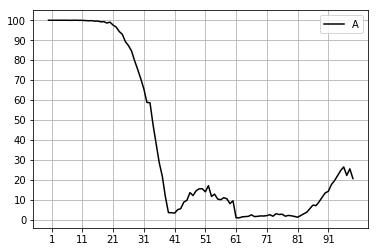

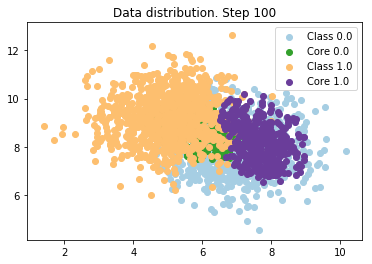

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[1])

from timeit import default_timer as timer
import numpy as np
import pandas as pd
import setup
from source import plotFunctions
from source import metrics
import checkerboard
from methods import compose_gmm_version

%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import Audio, display


class Experiment():
     def __init__(self, method, densityFunction=None, poolSize=None, isBatchMode=None):
        #commom for all experiments
        self.method = method
        #self.initialLabeledDataPerc=0.05 #150 instances for keystroke database and 0.05 % for artificial databases
        self.isBatchMode = isBatchMode
        self.poolSize = poolSize
        self.usePCA=False
        #used only by gmm / kde process
        self.densityFunction=densityFunction
        self.excludingPercentage = 0.7
        self.K_variation = 3
        self.classifier='cluster_and_label'
        #used in alpha-shape version only
        self.CP=0.65
        self.alpha=0.5
        #used in kmeans_svm and compose only
        self.useSVM=False
        self.isImbalanced=False


def doExperiments(dataValues, dataLabels, datasetDescription, experiments, numberOfTimes, batches, labeledData):
    listOfAccuracies = []
    listOfMethods = []
    sizeOfBatch = int((len(dataLabels)-labeledData)/batches)#int(len(dataLabels)/batches)
    
    print(datasetDescription)
    print("{} batches of {} instances".format(batches, sizeOfBatch))
    print("\n\n")
    
    for name, e in experiments.items():
        CoreX = []
        CoreY = []
        elapsedTime = []
        accTotal = []
        accuracies=[]
        classes = list(set(dataLabels))#getting all possible classes existent in data
        e.sizeOfBatch = sizeOfBatch
        e.batches = batches
        e.dataLabels = dataLabels
        e.dataValues = dataValues
        e.clfName = 'cl' #rf = random forests, cl = cluster and label, knn = k-nn, svm = svm

        for i in range(numberOfTimes):
            start = timer()
            #accuracy per step
            algorithmName, accuracies, CoreX, CoreY, arrX, arrY, arrUt, arrYt, arrClf = e.method.start(dataValues=e.dataValues, dataLabels=e.dataLabels, usePCA=e.usePCA, classes=classes, classifier=e.classifier, densityFunction=e.densityFunction, batches=e.batches, sizeOfBatch = e.sizeOfBatch, initialLabeledData=labeledData, excludingPercentage=e.excludingPercentage, K_variation=e.K_variation, CP=e.CP, alpha=e.alpha, clfName=e.clfName , useSVM=e.useSVM, isImbalanced=e.isImbalanced, poolSize=e.poolSize, isBatchMode=e.isBatchMode)
            end = timer()
            averageAccuracy = np.mean(accuracies)

            #elapsed time per step
            elapsedTime.append(end - start)
            
            accTotal.append(averageAccuracy)
        
        listOfAccuracies.append(accuracies)
        listOfMethods.append(algorithmName)
        #print("Total of ", numberOfTimes, " experiment iterations with an average accuracy of ", np.mean(accTotal))
        print("Average execution time: ", np.mean(elapsedTime))
        metrics.finalEvaluation(accuracies, batches)
    
        #print data distribution in step t
        initial = (batches*sizeOfBatch)-sizeOfBatch
        final = initial + sizeOfBatch
        plotFunctions.plot(dataValues[initial:final], dataLabels[initial:final], CoreX, CoreY, batches)
        print("\n\n")
        

def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    steps = 100
    initialLabeledData = 50
    
    #sinthetic
    dataValues, dataLabels, description = setup.loadCDT(path, sep)
    dataValues, dataLabels, description = setup.loadCHT(path, sep)
    dataValues, dataLabels, description = setup.load2CDT(path, sep)
    dataValues, dataLabels, description = setup.load2CHT(path, sep)
    dataValues, dataLabels, description = setup.loadUG_2C_2D(path, sep)
    dataValues, dataLabels, description = setup.loadUG_2C_3D(path, sep)
    dataValues, dataLabels, description = setup.loadUG_2C_5D(path, sep)
    dataValues, dataLabels, description = setup.loadMG_2C_2D(path, sep)
    dataValues, dataLabels, description = setup.loadFG_2C_2D(path, sep)
    dataValues, dataLabels, description = setup.loadGEARS_2C_2D(path, sep)
    dataValues, dataLabels, description = setup.loadCSurr(path, sep)
    '''dataValues, dataLabels, description = setup.load5CVT(path, sep)
    dataValues, dataLabels, description = setup.load4CR(path, sep)
    dataValues, dataLabels, description = setup.load4CRE_V1(path, sep)
    dataValues, dataLabels, description = setup.load4CRE_V2(path, sep)
    dataValues, dataLabels, description = setup.load4CE1CF(path, sep)
    dataValues, dataLabels, description = setup.loadCheckerBoard(path, sep)
    #real
    dataValues, dataLabels, description = setup.loadNOAADataset(path, sep)
    dataValues, dataLabels, description = setup.loadKeystroke(path, sep)
    dataValues, dataLabels, description = setup.loadElecData(path, sep)'''
    
    ''' COMPOSE (GMM extracting core supports) '''
    experiments[0] = Experiment(compose_gmm_version, "gmm", None, True)
    
    '''
    #running pywidget
    def run(batches):
        doExperiments(dataValues, dataLabels, description, experiments, 1, batches)
        
    v = interact(run, batches=(1, 100, 1));
    display(v)
    '''
    #params: X, y, method, num of experiment repetitions, num of batches
    doExperiments(dataValues, dataLabels, description, experiments, 1, steps, initialLabeledData)
    
if __name__ == "__main__":
    main()